# Big Shadow State Tomography

In [43]:
import numpy as np

from time import time
from tqdm import tqdm

import qiskit

from qiskit_aer import AerSimulator
from qiskit.visualization import plot_gate_map 

from qiskit_ibm_runtime.fake_provider import FakeLimaV2
from qiskit_ibm_runtime.fake_provider import FakeMontrealV2
from qiskit_ibm_runtime.fake_provider import FakeKyiv

from qiskit.circuit.random import random_circuit

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%cd -q ../..

from rivet_transpiler import transpile_right

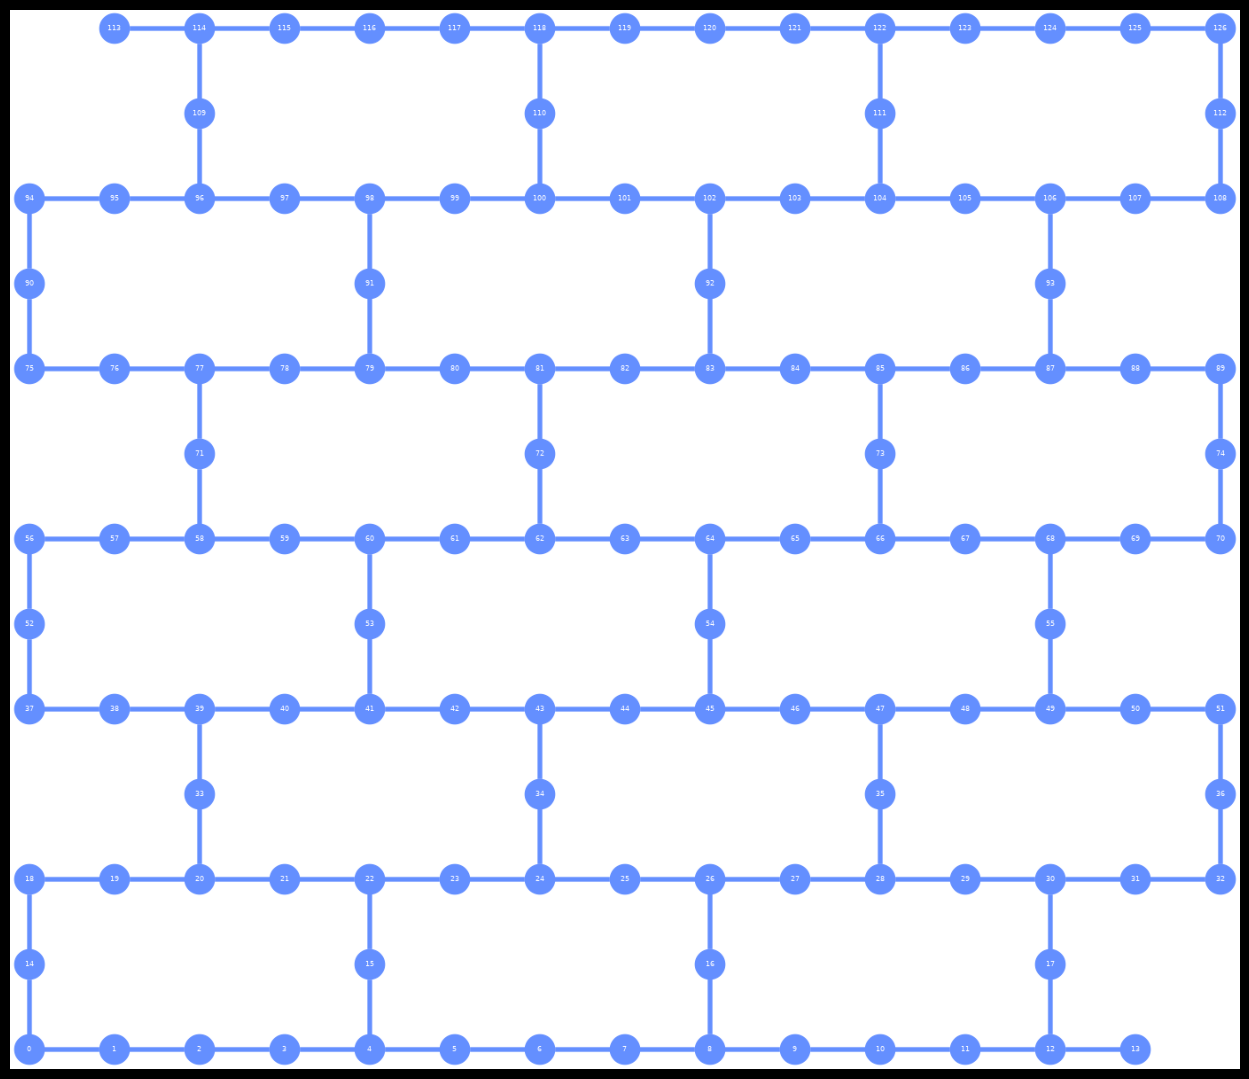

In [45]:
FAKE_BACKEND = FakeKyiv()

backend = AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

#### 3.3. Functions

In [4]:
def get_ghz_circuit(qubits_count):

    qubits = list(range(qubits_count))

    circuit = qiskit.QuantumCircuit(qubits_count)

    circuit.h(0)

    for control, target in zip(qubits, qubits[1:]):

        circuit.cx(control, target)

    return circuit

In [5]:
def rotate_qubit_to_basis(circuit, qubit, basis):

    if basis == "X":
        circuit.h(qubit)

    elif basis == "Y":
        circuit.sdg(qubit)
        circuit.h(qubit)

    elif basis == "Z":
        pass

In [6]:
def build_bases_rotation_circuit(bases):

    qubits_count = len(bases)

    circuit = qiskit.QuantumCircuit(qubits_count)

    for qubit, basis in enumerate(bases):

        if basis == "X":
            circuit.h(qubit)

        elif basis == "Y":
            circuit.sdg(qubit)
            circuit.h(qubit)

        elif basis == "Z":
            pass

    return circuit

In [7]:
def get_inverted_channel(channel, qubits_count):

    identity = np.eye(2 ** qubits_count)

    inverted_channel = (2 ** qubits_count + 1) * channel - identity

    return inverted_channel

In [8]:
def get_basis_unitary(basis):

    if basis == "X":
        unitary = 1/np.sqrt(2) * np.array([[1.,1.],
                                           [1.,-1.]])
    elif basis == "Y":
        unitary = 1/np.sqrt(2) * np.array([[1.,-1.0j],
                                           [1.,1.j]])
    elif basis == "Z":
        unitary = np.eye(2)

    return unitary

In [9]:
def get_mean_square_error(a, b):

    mean_square_error = np.abs(((a - b) ** 2).mean())

    return mean_square_error

## 4. Experiments and Results


Below for the case  of Shadow State Tomography we will reconstruct density matrix, which corresponds to “original circuit”. We build a list of “measurement circuits” which perform rotation of measurement bases. Then we compare 2 types of transpilation:

- **Basic Transpilation:** every “measurement circuit” is composed to “original circuit” – and then composed circuit is transpiled.

- **Rivet transpilation** using the function `transpile_right`: we transpile “original circuit” only once – and then use `transpile_right` function of Rivet Transpiler – to transpile only “measurement circuit” part.

Since “measurement circuit” is much smaller than “original circuit” – `transpile_right` approach is expected to be much faster.

### 4.1. Set Up a Circuit
#### 4.1.1. Circuit with a Random Seed

In [10]:
QUBITS_COUNT = 3
SU2_LAYERS_COUNT = 10
PARAMETRIZATION_RATIO = 0.25

OPTIMIZATION_LEVEL = 3

SEED = 1234

In [11]:
#import numpy as np
qubits = list(range(QUBITS_COUNT))
rng = np.random.default_rng(SEED) 

#### 4.1.2.  Parametrized SU2 Circuit

In [12]:
# Non-Parametrized Part

left_part = qiskit.QuantumCircuit(QUBITS_COUNT)
right_part = qiskit.QuantumCircuit(QUBITS_COUNT)

non_parametrized_layers_count = SU2_LAYERS_COUNT * 2 * (1 / PARAMETRIZATION_RATIO - 1)

non_parametrized_layers_count = int(non_parametrized_layers_count)

for left_layer in range(non_parametrized_layers_count // 2):
    left_part.rz(0.5, qubits)
    
for right_layer in range(non_parametrized_layers_count // 2):
    right_part.rz(1.5, qubits)   
    
# Parametrized Part

parametrized_part = qiskit.circuit.library.EfficientSU2(
    num_qubits=QUBITS_COUNT,
    reps=SU2_LAYERS_COUNT,
    entanglement="linear",
    skip_final_rotation_layer=True
)

# Compose Parts

parametrized_part = parametrized_part.decompose()

parametrized_circuit = parametrized_part.compose(left_part, front=True)
parametrized_circuit = parametrized_circuit.compose(right_part)

# Bind Parameters

random_parameters = np.random.rand(parametrized_circuit.num_parameters)

circuit = parametrized_circuit.assign_parameters(random_parameters)

print("circuit.depth():", circuit.depth())

# circuit.draw(fold=-1)

circuit.depth(): 100


#### 4.1.3.  Other Circuits

In [13]:
## GHZ Circuit

circuit = get_ghz_circuit(QUBITS_COUNT)
circuit.draw(fold=-1)

## Random Circuit

# circuit = random_circuit(QUBITS_COUNT, depth=20, max_operands=1, measure=False)

┌───┐          
q_0: ┤ H ├──■───────
     └───┘┌─┴─┐     
q_1: ─────┤ X ├──■──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

### 4.2.  Run Paulis Experiment

In [14]:
TOTAL_SHOTS_COUNT = 1000

- Define Bases

In [15]:
import random
random_bases = rng.choice(['X','Y','Z'], size=(TOTAL_SHOTS_COUNT, QUBITS_COUNT))

bases_list, shots_counts = np.unique(random_bases, axis=0, return_counts=True)

bases_list.shape

(27, 3)

- Define Rotation Circuits

In [16]:
rotation_circuits = []

for bases in bases_list:

    rotation_circuit = build_bases_rotation_circuit(bases)

    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

27

#### 4.2.1. Basic Transpilation - Slower Version!

To be able run code bellow need to install `tqdm`:


In [17]:
# !pip install tqdm

Here we use the simple transpilation while using `transpile` function. 

In [18]:
start_time = time()

# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    measured_circuit = circuit.compose(measurement_circuit)

    # display(measured_circuit.draw(fold=-1))

    shadow_circuit = qiskit.transpile(
        measured_circuit,
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 38.64 basis/s]

estimated_time: 0.70


#### 4.2.2. Transpile Right - Much Faster!
In this case we  run transpilation with `transpile_right` function.

In [19]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit,
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    shadow_circuit = transpile_right(
        transpiled_central_circuit,
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)


estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|█████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 72.20 basis/s]

estimated_time: 0.39


#### 4.2.3. Run Shadow Circuits

In [20]:
counts_list = []

for shadow_circuit, shots in zip(shadow_circuits, shots_counts):

    job = backend.run(shadow_circuit, shots=shots)

    counts = job.result().get_counts()

    counts_list.append(counts)

#### 4.2.4. Calculate Shadows

Calculate the shadow matrices for a set of observed states used to estimate the quantum state of the system.

In [21]:
shadows = []

for bases, counts in zip(bases_list, counts_list):

    for state, count in counts.items():

        shadow_part = 1

        for bit_index, bit in enumerate(state[::-1]):

            basis = bases[bit_index]

            basis_unitary = get_basis_unitary(basis)

            vector = basis_unitary[int(bit), :]

            outer_product = np.outer(vector.conj(), vector)

            inverted_channel = get_inverted_channel(outer_product, 1)

            shadow_part = np.kron(inverted_channel, shadow_part)

        shadow = shadow_part * count

        shadows.append(shadow)

#### 4.2.5. Analyze Density Matrices

In [22]:
reconstructed_density_matrix = np.sum(shadows, axis=0) / TOTAL_SHOTS_COUNT

reconstructed_density_matrix.shape

(8, 8)

In [23]:
original_density_matrix = qiskit.quantum_info.DensityMatrix(circuit).data

original_density_matrix.shape

(8, 8)

Below we plot the visualization for **ORIGINAL** and **RECONSTRUCTED** Density Matrices:

In [24]:
def plot_density_matrix(density_matrix, label=""):

    plt.suptitle(f"{label} Density Matrix", y=0.9)

    real = plt.subplot(121)
    real.set_title("Real part")

    real.imshow(density_matrix.real, vmin=-0.7, vmax=0.7)

    real.axes.set_xticks(())
    real.axes.set_yticks(())


    imaginary = plt.subplot(122)
    imaginary.set_title("Imaginary part")
    imaginary.imshow(density_matrix.imag, vmin=-0.7, vmax=0.7)

    imaginary.axes.set_xticks(())
    imaginary.axes.set_yticks(())

    plt.show()

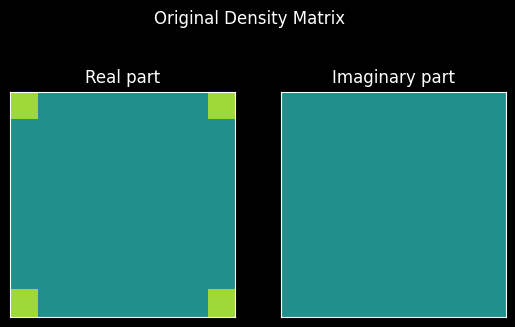

In [25]:
plot_density_matrix(original_density_matrix, label="Original")

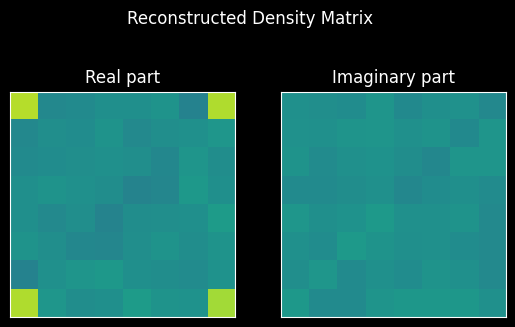

In [26]:
plot_density_matrix(reconstructed_density_matrix, label="Reconstructed")

To measure a Mean Square Error:

In [27]:
mean_square_error = np.abs(((original_density_matrix -
                             reconstructed_density_matrix) ** 2).mean())

mean_square_error

0.0004419101562499986

### 4.3.  Run Cliffords Experiment

In [28]:
SHADOWS_COUNT = 100
SHOTS_COUNT = 100

cliffords = [qiskit.quantum_info.random_clifford(QUBITS_COUNT, seed=rng)
             for _ in range(SHADOWS_COUNT)]

- Define Rotation Circuits:

In [29]:
rotation_circuits = []

for clifford in cliffords:

    rotation_circuit = clifford.to_circuit()

    rotation_circuits.append(rotation_circuit)

len(rotation_circuits)

100

#### 4.3.1. Basic Transpilation - Slower Version!

In [30]:
start_time = time()

# Compose and Transpile all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    measured_circuit = circuit.compose(measurement_circuit)

    # display(measured_circuit.draw(fold=-1))

    shadow_circuit = qiskit.transpile(
        measured_circuit,
        backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)

estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 22.69 basis/s]

estimated_time: 4.41


#### 4.3.2. Transpile Right - Much Faster!

In [31]:
start_time = time()

# Transpile Central Part

transpiled_central_circuit = qiskit.transpile(
    circuit,
    backend,
    seed_transpiler=SEED,
    optimization_level=OPTIMIZATION_LEVEL)


# Transpile Right all Rotation Circuits

shadow_circuits = []

rotation_tracker = tqdm(rotation_circuits, unit=' basis', ncols=110)

for rotation_circuit in rotation_tracker:

    measurement_circuit = rotation_circuit.measure_all(inplace=False)

    shadow_circuit = transpile_right(
        transpiled_central_circuit,
        measurement_circuit,
        backend=backend,
        seed_transpiler=SEED,
        optimization_level=OPTIMIZATION_LEVEL)

    shadow_circuits.append(shadow_circuit)


estimated_time = time() - start_time

print(f"estimated_time: {estimated_time:.02f}")

100%|███████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.97 basis/s]

estimated_time: 3.47


#### 4.3.3.  Run Shadow Circuits

In [32]:
counts_list = []

for shadow_circuit in shadow_circuits:

    job = backend.run(shadow_circuit, shots=SHOTS_COUNT)

    counts = job.result().get_counts()

    counts_list.append(counts)

#### 4.3.4.  Calculate Shadows

Calculate the shadow matrices for a set of observed states used to estimate the quantum state of the system.

In [33]:
shadows = []

for clifford, counts in zip(cliffords, counts_list):

    unitary = clifford.adjoint().to_matrix()

    for state, count in counts.items():

        state_index = int(state, 2)

        vector = unitary[:, state_index]

        outer_product = np.outer(vector, vector.conj())

        inverted_channel = get_inverted_channel(outer_product, QUBITS_COUNT)

        shadow = inverted_channel * count

        shadows.append(shadow)

#### 4.3.5.  Analyze Density Matrices

In [34]:
TOTAL_SHOTS_COUNT = SHADOWS_COUNT * SHOTS_COUNT

reconstructed_density_matrix = np.sum(shadows, axis=0) / TOTAL_SHOTS_COUNT

reconstructed_density_matrix.shape

(8, 8)

In [35]:
original_density_matrix = qiskit.quantum_info.DensityMatrix(circuit).data

original_density_matrix.shape

(8, 8)

Below we plot the visualization for **ORIGINAL** and **RECONSTRUCTED** Density Matrices:

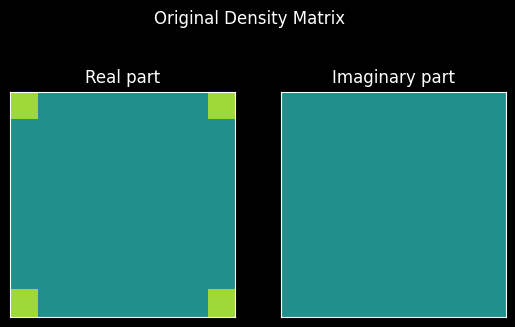

In [36]:
plot_density_matrix(original_density_matrix, label="Original")

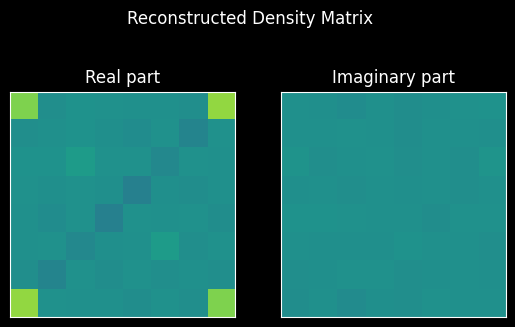

In [37]:
plot_density_matrix(reconstructed_density_matrix, label="Reconstructed")

To measure a Mean Square Error:

In [38]:
get_mean_square_error(original_density_matrix,
                      reconstructed_density_matrix)

0.0007780460937499958

### 4.4.  Compare Transpilation Times
Below we compare the transpilation times for a few circuits (from 2 to 8 qubits) using the basic transpilation and transpilation with a `transpile_right`.

In [39]:
results = np.load("examples/shadows/results.npy",
                  allow_pickle=True).item()
results

{2: {'bases': 9, 'basic_transpilation': 2.15, 'transpile_right': 0.27},
 3: {'bases': 27, 'basic_transpilation': 20.03, 'transpile_right': 1.14},
 4: {'bases': 81, 'basic_transpilation': 82.06, 'transpile_right': 2.74},
 5: {'bases': 243, 'basic_transpilation': 312.58, 'transpile_right': 7.39},
 6: {'bases': 729, 'basic_transpilation': 1150.28, 'transpile_right': 23.47},
 7: {'bases': 2167, 'basic_transpilation': 3939.58, 'transpile_right': 121.01},
 8: {'bases': 5127,
  'basic_transpilation': 10018.36,
  'transpile_right': 271.09}}

In [40]:
basic_times = [results[qubit_count]['basic_transpilation'] for qubit_count in results]

basic_times

[2.15, 20.03, 82.06, 312.58, 1150.28, 3939.58, 10018.36]

In [41]:
right_times = [results[qubit_count]['transpile_right'] for qubit_count in results]

right_times

[0.27, 1.14, 2.74, 7.39, 23.47, 121.01, 271.09]

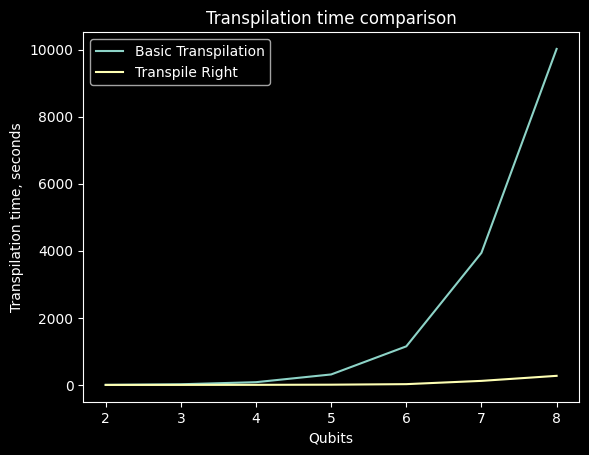

In [42]:
# Plot Transpilation times

qubit_counts = list(results.keys())

plt.title("Transpilation time comparison")
plt.xlabel("Qubits")
plt.ylabel("Transpilation time, seconds")

plt.plot(qubit_counts, basic_times, label="Basic Transpilation")
plt.plot(qubit_counts, right_times, label="Transpile Right")

plt.legend()

plt.show()

## Conclusions

For the shadow state tomography technique we reconstructed the density matrix of the “original circuit” and compared 2 types of transpilation: 
- **Basic Transpilation:** every “measurement circuit” is composed to “original circuit” – and then composed circuit is transpiled.
- **Rivet transpilation** using the function `transpile_right`: we transpile “original circuit” only once – and then use `transpile_right` function of Rivet Transpiler – to transpile only “measurement circuit” part.

Through this experiment, it was shown that using transpile_left is a faster approach.


## References

[1] https://hongyehu.github.io/Hamiltonian-driven-shadow-tomography-page/

[2] https://github.com/ryanlevy/shadow-tutorial/blob/main/Tutorial_Shadow_State_Tomography.ipynb

[3] https://arxiv.org/pdf/2002.08953

[4] Qiskit fake backends https://docs.quantum.ibm.com/api/qiskit/0.37/providers_fake_provider